# 🏞 합성곱 신경망

### 변경점
* 변경점 : 커스텀 데이터셋을 추가하는 방법에 대한 코드를 추가해 보았습니다.

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/02_deeplearning/02_cnn/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

이 노트북에서는 CIFAR 데이터셋에서 합성곱 신경망(CNN)을 훈련하는 데 필요한 단계를 소개합니다.

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 utils.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
    !mkdir -p notebooks
    !mv utils.py notebooks

--2024-01-15 16:54:06--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     771  --.-KB/s    in 0s      

2024-01-15 16:54:06 (38.3 MB/s) - ‘utils.py’ saved [771/771]



In [2]:
import numpy as np

from tensorflow.keras import layers, models, optimizers, utils, datasets
from notebooks.utils import display

## 0. 파라미터 <a name="parameters"></a>

In [32]:
NUM_CLASSES = 5

## 1. 데이터 준비 <a name="prepare"></a>
### 1) 데이터 불러오기 및 구조 확인

* 꽃의 종류를 분류하는 flowers 데이터셋을 구글 드라이브에 별도로 저장해 놓았습니다.
* 이를 불러와 구조를 확인해 보겠습니다.

In [5]:
# 구들 드라이브에 있는 데이터셋 가지오기
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [14]:
# 연동이 되었는지 확인
import os
os.listdir("/content/gdrive/MyDrive/Colab Notebooks/스터디/notebooks/02_deeplearning/02_cnn/datasets")

['flowers']

* 데이터가 있는 것이 확인되었으니 경로를 설정합니다.

In [15]:
DATA_PATH = "/content/gdrive/MyDrive/Colab Notebooks/스터디/notebooks/02_deeplearning/02_cnn/datasets"

In [17]:
os.listdir(DATA_PATH+'/flowers')

['dandelion', 'sunflower', 'tulip', 'rose', 'daisy']

데이터의 구조를 확인해본 결과 다음과 같이 루트 디렉토리에서 각 범주(클래스별로) 폴더가 나뉘어 있으며,</br></br>
각 폴더의 내부에는 해당 범주에 속하는 이미지들이 저장되어 있습니다.

```
main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg
```

이와 같은 구조는 `keras.utils.image_dataset_from_directory`를 사용하면, 쉽게 불러오는 것이 가능합니다.

* 참고 : [`tf.keras.utils.image_data_from_directory`](https://tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)

In [75]:
# 데이터셋 불러오기
from tensorflow.keras.utils import image_dataset_from_directory

dataset = image_dataset_from_directory(
    directory = os.path.join(DATA_PATH, 'flowers'),
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256,256),
    shuffle=True,
    seed=100,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear'
)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.


In [76]:
# 검증 데이터셋
val_dataset = image_dataset_from_directory(
    directory = os.path.join(DATA_PATH, 'flowers'),
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=1,
    image_size=(256,256),
    shuffle=True,
    seed=100,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear'
)

Found 4317 files belonging to 5 classes.
Using 863 files for validation.


['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
(32, 256, 256, 3) (32, 5)
tf.Tensor(
[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]], shape=(32, 5), dtype=float32)


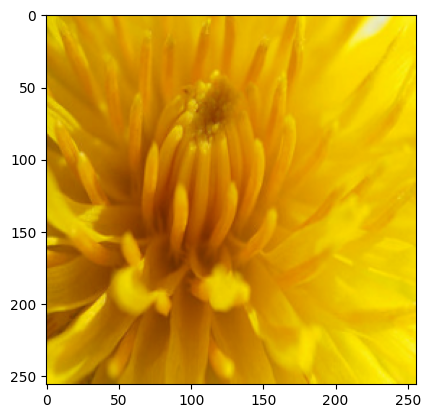

In [77]:
from matplotlib import pyplot as plt

# 클래스명 확인
print(dataset.class_names)
# 샘플 가져와보기
for data, label in dataset.take(1):
  print(data.shape, label.shape)
  print(label)
  plt.imshow(data[0].numpy().astype(np.uint8))

### 2) 간단한 전처리
불러오는 것은 문제가 없는 것이 확인되었으니, 용이한 학습이 가능하도록 정규화와 같은 간단한 전처리를 추가해 줍시다.
</br>
`keras.utils.image_dataset_from_directory`로 불러모아진 데이터셋은 `tensorflow.python.data.Dataset`이라는 객체의 인스턴스임을 활용하면 손쉬운 처리가 가능합니다.

In [78]:
# 범위 [0,255]에서 [0.,1.]로 정규화
def normalize_image(x, y):
  return x / 255.0, y

# 모든 데이터에 적용
dataset = dataset.map(normalize_image)

In [79]:
# 검증 데이터셋에도 적용
val_dataset = val_dataset.map(normalize_image)

In [80]:
# 확인
for data, label in dataset.take(1):
  data_numpy = data.numpy()
  print(np.min(data_numpy), np.max(data_numpy))

0.0 1.0


## 2. 모델 만들기 <a name="build"></a>

In [63]:
input_layer = layers.Input((256, 256, 3))

x = layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(
    input_layer
)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.GlobalMaxPooling2D()(x)

x = layers.Dense(32)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Dense(NUM_CLASSES)(x)
output_layer = layers.Activation("softmax")(x)

model = models.Model(input_layer, output_layer)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_19 (Ba  (None, 256, 256, 32)      128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 256, 256, 32)      0         
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_20 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                         

## 3. 모델 훈련 <a name="train"></a>

In [64]:
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(
    loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"]
)

In [65]:
model.fit(
    dataset,
    epochs=10,
    validation_data=val_dataset,
)

Epoch 1/10
108/108 [==============================] - 431s 4s/step - loss: 1.3249 - accuracy: 0.4627 - val_loss: 1.9779 - val_accuracy: 0.2364
Epoch 2/10
108/108 [==============================] - 24s 211ms/step - loss: 1.0616 - accuracy: 0.5834 - val_loss: 2.2805 - val_accuracy: 0.2364
Epoch 3/10
108/108 [==============================] - 23s 202ms/step - loss: 0.9625 - accuracy: 0.6332 - val_loss: 1.7182 - val_accuracy: 0.2688
Epoch 4/10
108/108 [==============================] - 23s 204ms/step - loss: 0.8920 - accuracy: 0.6616 - val_loss: 1.2406 - val_accuracy: 0.4635
Epoch 5/10
108/108 [==============================] - 23s 208ms/step - loss: 0.8437 - accuracy: 0.6841 - val_loss: 0.9480 - val_accuracy: 0.6501
Epoch 6/10
108/108 [==============================] - 23s 207ms/step - loss: 0.8109 - accuracy: 0.6946 - val_loss: 0.8628 - val_accuracy: 0.6732
Epoch 7/10
108/108 [==============================] - 23s 206ms/step - loss: 0.7549 - accuracy: 0.7247 - val_loss: 0.8120 - val_accu

## 4. 평가 <a name="evaluate"></a>

In [66]:
model.evaluate(val_dataset)

27/27 [==============================] - 4s 120ms/step - loss: 0.7556 - accuracy: 0.7161


[0.7556223273277283, 0.7161065936088562]

In [86]:
# CLASSES = ['dandelion', 'sunflower', 'tulip', 'rose', 'daisy']
# # val_dataset = val_dataset.repeat(1)
# preds = model.predict(val_dataset)

# y_test = []
# for _, label in val_dataset:
#   y_test.append(label.numpy())
# y_test = np.asarray(y_test)

# preds_single = CLASSES[np.argmax(preds, axis=-1)]
# actual_single = CLASSES[np.argmax(y_test, axis=-1)]

In [87]:
# preds

In [88]:
# import matplotlib.pyplot as plt

# n_to_show = 10
# indices = np.random.choice(range(len(val_dataset)), n_to_show)

# fig = plt.figure(figsize=(15, 3))
# fig.subplots_adjust(hspace=0.4, wspace=0.4)

# for i, idx in enumerate(indices):
#     img = x_test[idx]
#     ax = fig.add_subplot(1, n_to_show, i + 1)
#     ax.axis("off")
#     ax.text(
#         0.5,
#         -0.35,
#         "pred = " + str(preds_single[idx]),
#         fontsize=10,
#         ha="center",
#         transform=ax.transAxes,
#     )
#     ax.text(
#         0.5,
#         -0.7,
#         "act = " + str(actual_single[idx]),
#         fontsize=10,
#         ha="center",
#         transform=ax.transAxes,
#     )
#     ax.imshow(img)